## Prediction duration of a ride based on NYC cabs records
[Dataset](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

Model to be deployed using MLOps techniques.

In [11]:
import pickle 

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

/workspaces/mlops/env/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2025/09/16 13:57:41 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/09/16 13:57:41 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/workspaces/mlops/mlruns/1', creation_time=1758028115681, experiment_id='1', last_update_time=1758028115681, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [4]:
def prep_data(filename):
    df = pd.read_parquet(filename)
    
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']
    categorical = ['PU_DO']
    numerical = ['trip_distance']
    
    x_dicts = df[categorical + numerical].to_dict(orient='records')

    target = 'duration'
    y = df[target].values
    
    return x_dicts, y

In [5]:
train_data_path = 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet'
validation_data_path = 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet'


train_dicts, y_train = prep_data(train_data_path)
validation_dicts, y_validation = prep_data(validation_data_path)

dv = DictVectorizer() # need to be the same (tokenize)

X_train = dv.fit_transform(train_dicts)  
X_validation = dv.transform(validation_dicts)  

In [9]:
with mlflow.start_run():

    mlflow.set_tag("developer", "aline")

    mlflow.log_param("train-data-path", train_data_path)
    mlflow.log_param("validation-data-path", validation_data_path)
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_validation)
    rmse = root_mean_squared_error(y_validation, y_pred) # minutes error

    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path="models/lin_reg.bin")

/tmp/ipykernel_19284/2292603881.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_19284/2292603881.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_validation, label='actual')


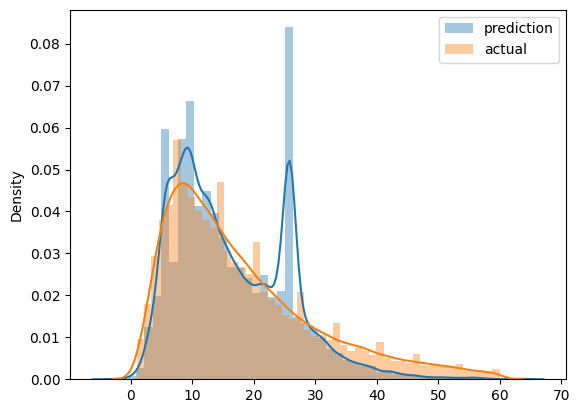

In [6]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_validation, label='actual')

plt.legend()

In [7]:
l = Lasso(alpha=0.001)
l.fit(X_train, y_train)

y_pred = l.predict(X_validation)
root_mean_squared_error(y_validation, y_pred) # minutes error

9.23343622815571

In [8]:
with open('models/lin_reg.bin', 'wb') as f_out: # saving model as it was the best, manual work and no versioning
    pickle.dump((dv, lr), f_out)

In [9]:
# might be interesting to track the results for each model, by taking notes or using Experiment Tracker
# Model Registry shows more info on models (which one, its metrics)
# Keeping track of historical metrics - MLFlow

In [10]:
from mermaid import Mermaid

mermaid_code = """
flowchart TD
    A[Load and Prepare Data] --> B[Vectorize]
    B --> C[Train]
"""

chart = Mermaid(mermaid_code)

In [11]:
chart # steps in this notebook that will be transformed in a mlops pipeline

In [13]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_validation, label=y_validation)

In [21]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_validation, y_pred)

        mlflow.log_metric("rmse", rmse)

        return {"loss": rmse, "status": STATUS_OK}

# mlflow.xgboost.autolog()

In [22]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, 0),
    'reg_lambda': hp.loguniform('reg_lambda', -6, 0),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

In [ ]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|                                                                                                                  | 0/50 [00:00<?, ?trial/s, best loss=?]

/workspaces/mlops/env/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:36:04] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.71526                                                                                                                                  
[1]	validation-rmse:11.25651                                                                                                                                  
[2]	validation-rmse:10.83480                                                                                                                                  
[3]	validation-rmse:10.44795                                                                                                                                  
[4]	validation-rmse:10.09255                                                                                                                                  
[5]	validation-rmse:9.76669                                                                                                                                   
[6]	validation-rmse:9.46913                   

/workspaces/mlops/env/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:40:34] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:6.86156                                                                                                                                   
[1]	validation-rmse:6.53845                                                                                                                                   
[2]	validation-rmse:6.48110                                                                                                                                   
[3]	validation-rmse:6.46729                                                                                                                                   
[4]	validation-rmse:6.45323                                                                                                                                   
[5]	validation-rmse:6.44327                                                                                                                                   
[6]	validation-rmse:6.43335                   

/workspaces/mlops/env/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:41:08] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.07914                                                                                                                                   
[1]	validation-rmse:7.70784                                                                                                                                   
[2]	validation-rmse:7.15248                                                                                                                                   
[3]	validation-rmse:6.92251                                                                                                                                   
[4]	validation-rmse:6.82270                                                                                                                                   
[5]	validation-rmse:6.76714                                                                                                                                   
[6]	validation-rmse:6.73769                   

/workspaces/mlops/env/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:42:51] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.77308                                                                                                                                  
[1]	validation-rmse:11.36431                                                                                                                                  
[2]	validation-rmse:10.98427                                                                                                                                  
[3]	validation-rmse:10.63241                                                                                                                                  
[4]	validation-rmse:10.30675                                                                                                                                  
[5]	validation-rmse:10.00506                                                                                                                                  
[6]	validation-rmse:9.72559                   

/workspaces/mlops/env/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:45:40] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.69191                                                                                                                                   
[1]	validation-rmse:8.26819                                                                                                                                   
[2]	validation-rmse:7.51197                                                                                                                                   
[3]	validation-rmse:7.10749                                                                                                                                   
[4]	validation-rmse:6.89556                                                                                                                                   
[5]	validation-rmse:6.77888                                                                                                                                   
[6]	validation-rmse:6.70367                   

/workspaces/mlops/env/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:47:04] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.47279                                                                                                                                   
[1]	validation-rmse:6.71393                                                                                                                                   
[2]	validation-rmse:6.56603                                                                                                                                   
[3]	validation-rmse:6.52404                                                                                                                                   
[4]	validation-rmse:6.51379                                                                                                                                   
[5]	validation-rmse:6.50883                                                                                                                                   
[6]	validation-rmse:6.49936                   

/workspaces/mlops/env/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [13:47:36] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.38540                                                                                                                                  
 12%|██████████▍                                                                            | 6/50 [11:39<1:05:31, 89.36s/trial, best loss: 6.316493448368559]

In [18]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_validation, label=y_validation)

with mlflow.start_run():
    best_params = {
        'max_depth': 30,
        'learning_rate': 0.095853553,
        'reg_alpha': 0.01806024404,
        'reg_lambda': 0.0116587313,
        'min_child_weight': 1.0605970509,
        'objective': 'reg:linear',
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
                params=best_params,
                dtrain=train,
                num_boost_round=1000,
                evals=[(valid, "validation")],
                early_stopping_rounds=50
            )

    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_validation, y_pred)

    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b")
        
    mlflow.xgboost.log_model(booster)

/workspaces/mlops/env/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [14:32:30] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-rmse:11.44482
[1]	validation-rmse:10.77202
[2]	validation-rmse:10.18363
[3]	validation-rmse:9.67396
[4]	validation-rmse:9.23166
[5]	validation-rmse:8.84808
[6]	validation-rmse:8.51883
[7]	validation-rmse:8.23597
[8]	validation-rmse:7.99320
[9]	validation-rmse:7.78709
[10]	validation-rmse:7.61022
[11]	validation-rmse:7.45952
[12]	validation-rmse:7.33049
[13]	validation-rmse:7.22098
[14]	validation-rmse:7.12713
[15]	validation-rmse:7.04752
[16]	validation-rmse:6.98005
[17]	validation-rmse:6.92232
[18]	validation-rmse:6.87112
[19]	validation-rmse:6.82740
[20]	validation-rmse:6.78995
[21]	validation-rmse:6.75792
[22]	validation-rmse:6.72994
[23]	validation-rmse:6.70547
[24]	validation-rmse:6.68390
[25]	validation-rmse:6.66421
[26]	validation-rmse:6.64806
[27]	validation-rmse:6.63280
[28]	validation-rmse:6.61924
[29]	validation-rmse:6.60773
[30]	validation-rmse:6.59777
[31]	validation-rmse:6.58875
[32]	validation-rmse:6.58107
[33]	validation-rmse:6.57217
[34]	validation-rmse:

/workspaces/mlops/env/lib/python3.12/site-packages/mlflow/xgboost/__init__.py:169: UserWarning: [14:35:34] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/09/16 14:35:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
